# Tutorial 2 - Traffic Sign Classification with CNN and Adversarial Attacks

## 1. Setup and Data Preparation

In [ ]:
# !pip install torchcam

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
from torchvision.models import vgg11_bn
from torchcam.methods import GradCAM
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import os
import random

### 1.2 Set Device

In [ ]:
device = torch.devic
e("cuda" if torch.cuda.is_available() else "cpu") # set device
print(device)

cuda


### 1.3 Define Transformations

In [ ]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### 1.4 Load and Preprocess Dataset

In [ ]:
# Load the training and test datasets without transformations
train_dataset = datasets.GTSRB(root='./data', split='train', transform=None, download=True)
test_dataset = datasets.GTSRB(root='./data', split='test', transform=None, download=True)

# Function to check image size and resize if necessary
def conditional_resize(img, size=(32, 32), interpolation=Image.BICUBIC):
    if img.size != size:
        img = img.resize(size, interpolation)
    return img

# Apply the conditional resize and transformations to the datasets
train_dataset = [(conditional_resize(img, (32, 32)), label) for img, label in train_dataset]
test_dataset = [(conditional_resize(img, (32, 32)), label) for img, label in test_dataset]

# Apply the transformations to the resized datasets
train_dataset = [(transform(img), label) for img, label in train_dataset]
test_dataset = [(transform(img), label) for img, label in test_dataset]

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for the training, validation, and test datasets
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Print the size of the datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Training dataset size: 21312
Validation dataset size: 5328
Test dataset size: 12630


## 2. Model Definition
### 2.1 Define CNN Model

### Convolution Layers in PyTorch

Convolution layers are a fundamental building block of Convolutional Neural Networks (CNNs). They apply a set of filters (kernels) to the input data to extract features such as edges, textures, and patterns. In PyTorch, convolution layers are implemented using the `torch.nn.Conv2d` class. These layers perform convolution operations followed by optional activation functions and pooling layers to reduce the spatial dimensions.

For more information on different types of convolution layers, their number of operations, and visualizations, you can refer to the following GitHub repository:

[Different Types of Convolution Layers - GitHub Repository](https://github.com/ZaGrayWolf/Types_of_Convolutions)

This repository provides a comprehensive overview of various convolution operations, including standard convolutions, transposed convolutions, and dilated convolutions, along with visualizations of their effects on input data.

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, dilation)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjusted for 3x32x32 input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Batch normalization layers
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm_fc1 = nn.BatchNorm1d(512)
        self.batchnorm_fc2 = nn.BatchNorm1d(256)

    def forward(self, x):
        # Convolutional layers with ReLU and batch normalization
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU, batch normalization, and dropout
        x = F.relu(self.batchnorm_fc1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.batchnorm_fc2(self.fc2(x)))
        x = self.dropout(x)

        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Example usage
model = CNNModel(num_classes=43)
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### 2.2 Define Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 3. Training the Model:
### Training Loop and Plot Training and Validation Losses

Epoch 1/20, Training Loss: 3.3407, Validation Loss: 3.1171
Epoch 2/20, Training Loss: 3.1110, Validation Loss: 3.0562
Epoch 3/20, Training Loss: 3.0031, Validation Loss: 2.9601
Epoch 4/20, Training Loss: 2.9594, Validation Loss: 2.9406
Epoch 5/20, Training Loss: 2.9496, Validation Loss: 2.9420
Epoch 6/20, Training Loss: 2.9403, Validation Loss: 2.9167
Epoch 7/20, Training Loss: 2.9251, Validation Loss: 2.9077
Epoch 8/20, Training Loss: 2.9168, Validation Loss: 2.9068
Epoch 9/20, Training Loss: 2.9148, Validation Loss: 2.9052
Epoch 10/20, Training Loss: 2.9037, Validation Loss: 2.8890
Epoch 11/20, Training Loss: 2.8859, Validation Loss: 2.8794
Epoch 12/20, Training Loss: 2.8809, Validation Loss: 2.8777
Epoch 13/20, Training Loss: 2.8696, Validation Loss: 2.8602
Epoch 14/20, Training Loss: 2.8590, Validation Loss: 2.8543
Epoch 15/20, Training Loss: 2.8473, Validation Loss: 2.8433
Epoch 16/20, Training Loss: 2.8413, Validation Loss: 2.8318
Epoch 17/20, Training Loss: 2.8328, Validation Lo

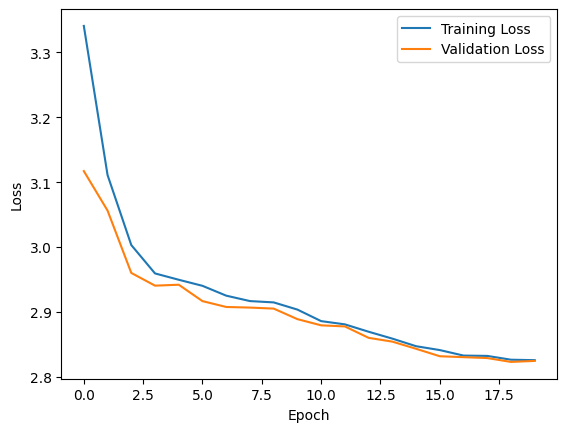

In [ ]:
num_epochs = 20
train_losses = []
val_losses = []
model=model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. Model Evaluation
### 4.1 Evaluate on Test Set

In [ ]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1

# Evaluate the model
test_accuracy, test_f1 = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.9376
Test F1 Score: 0.9301


## 5. Adversarial Attacks
### 5.1 FGSM Attack
The Fast Gradient Sign Method (FGSM) is a simple yet effective adversarial attack technique introduced by Goodfellow et al. in 2014. It aims to generate adversarial examples by adding a small perturbation to the input image in the direction of the gradient of the loss function with respect to the input. The perturbation is controlled by a parameter epsilon (ε), which determines the magnitude of the perturbation. The goal is to create an adversarial example that is visually similar to the original image but causes the model to make incorrect predictions.

For more information on FGSM and its implementation in PyTorch, you can refer to the official PyTorch documentation:

1.[PyTorch FGSM Tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
###
2.[Interactive Demo](https://jlin.xyz/advis/)

Additional Materials on Adversarial Attacks:
###
1.[ Explaining and Harnessing Adversarial Example](https://arxiv.org/abs/1412.6572)
###
2.[Different Types of Adversarial Attacks](https://arxiv.org/pdf/1804.00097)
###
3. [Adversarial Attacks on Speech Data](https://arxiv.org/pdf/1801.01944)
###


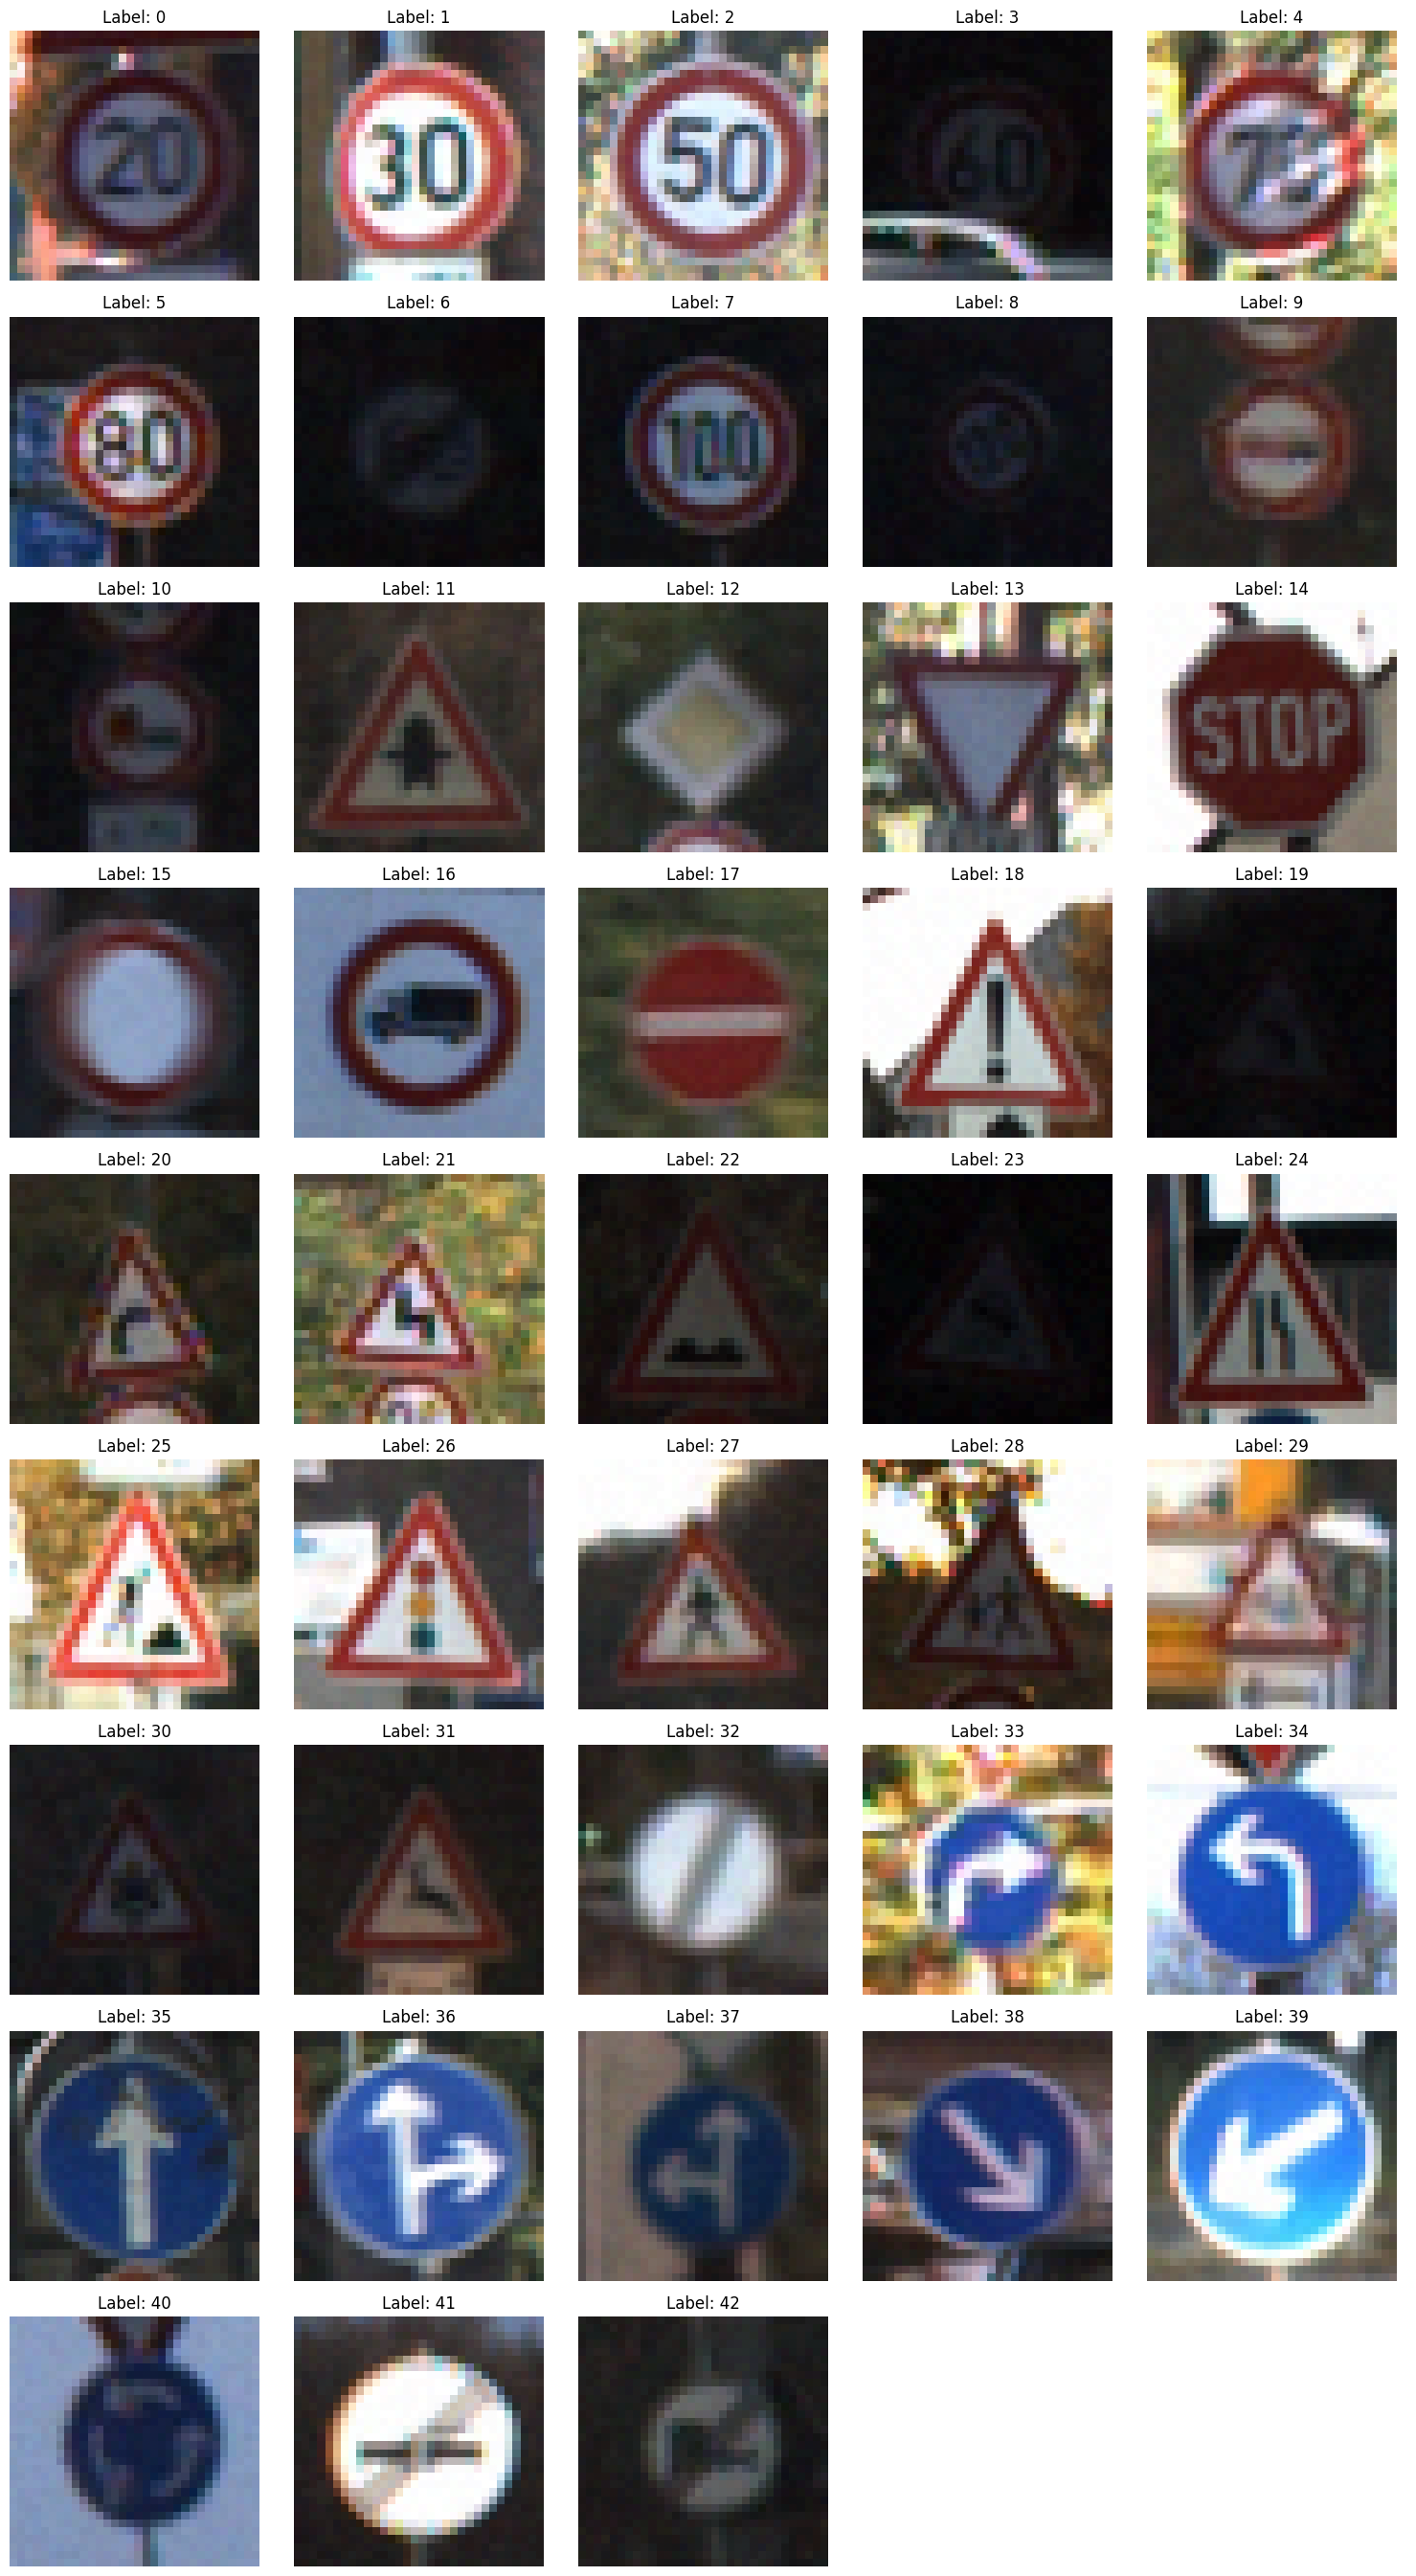

Adversarial Test Accuracy: 0.6032
Adversarial Test F1 Score: 0.6130


In [ ]:
# device='cpu'
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.5], std=[0.5]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

# Function to generate adversarial samples
def generate_adversarial_samples(model, test_loader, epsilon):
    model.eval()
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        loss = F.cross_entropy(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        perturbed_data=transforms.Normalize((0.5,), (0.5,))(perturbed_data)
        adv_examples.append((perturbed_data, target))

    return adv_examples

# Set the epsilon value for FGSM
epsilon = 0.01

# Generate adversarial samples
adv_samples = generate_adversarial_samples(model, test_loader, epsilon)

# Visualize some adversarial samples
def imshow(ax,img,title):
    img = denorm(img)
    img = img.squeeze().permute(1,2,0).detach().cpu().numpy()
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    # plt.show()


# Plot one sample for each label as a grid
num_labels = 43
num_cols = 5
num_rows = (num_labels + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Ensure axes is always a 2D array
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)
if num_cols == 1:
    axes = np.expand_dims(axes, axis=1)

for i in range(num_labels):
    row = i // num_cols
    col = i % num_cols
    for adv_img, label in adv_samples:
        if label.item() == i:
            imshow(axes[row, col], adv_img, f"Label: {label.item()}")
            break

# Hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# # Show a few examples of adversarial samples
# for i,label in range(num_labels):
#     for adv_img, label in adv_samples:
#         if label==i:
#             adv_img = denorm(adv_img)
#             print(f"Label: {label.item()}")
#             imshow(adv_img.squeeze())

# Evaluate the model on adversarial samples
def evaluate_adversarial_samples(model, adv_samples):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for adv_img, label in adv_samples:
            adv_img, label = adv_img.to(device), label.to(device)
            output = model(adv_img)
            _, pred = torch.max(output, 1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            correct += (pred == label).sum().item()
            total += label.size(0)

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1

# Evaluate the model on adversarial samples
adv_accuracy, adv_f1 = evaluate_adversarial_samples(model, adv_samples)
print(f"Adversarial Test Accuracy: {adv_accuracy:.4f}")
print(f"Adversarial Test F1 Score: {adv_f1:.4f}")

### 5.2 Generate and Visualize Adversarial Samples

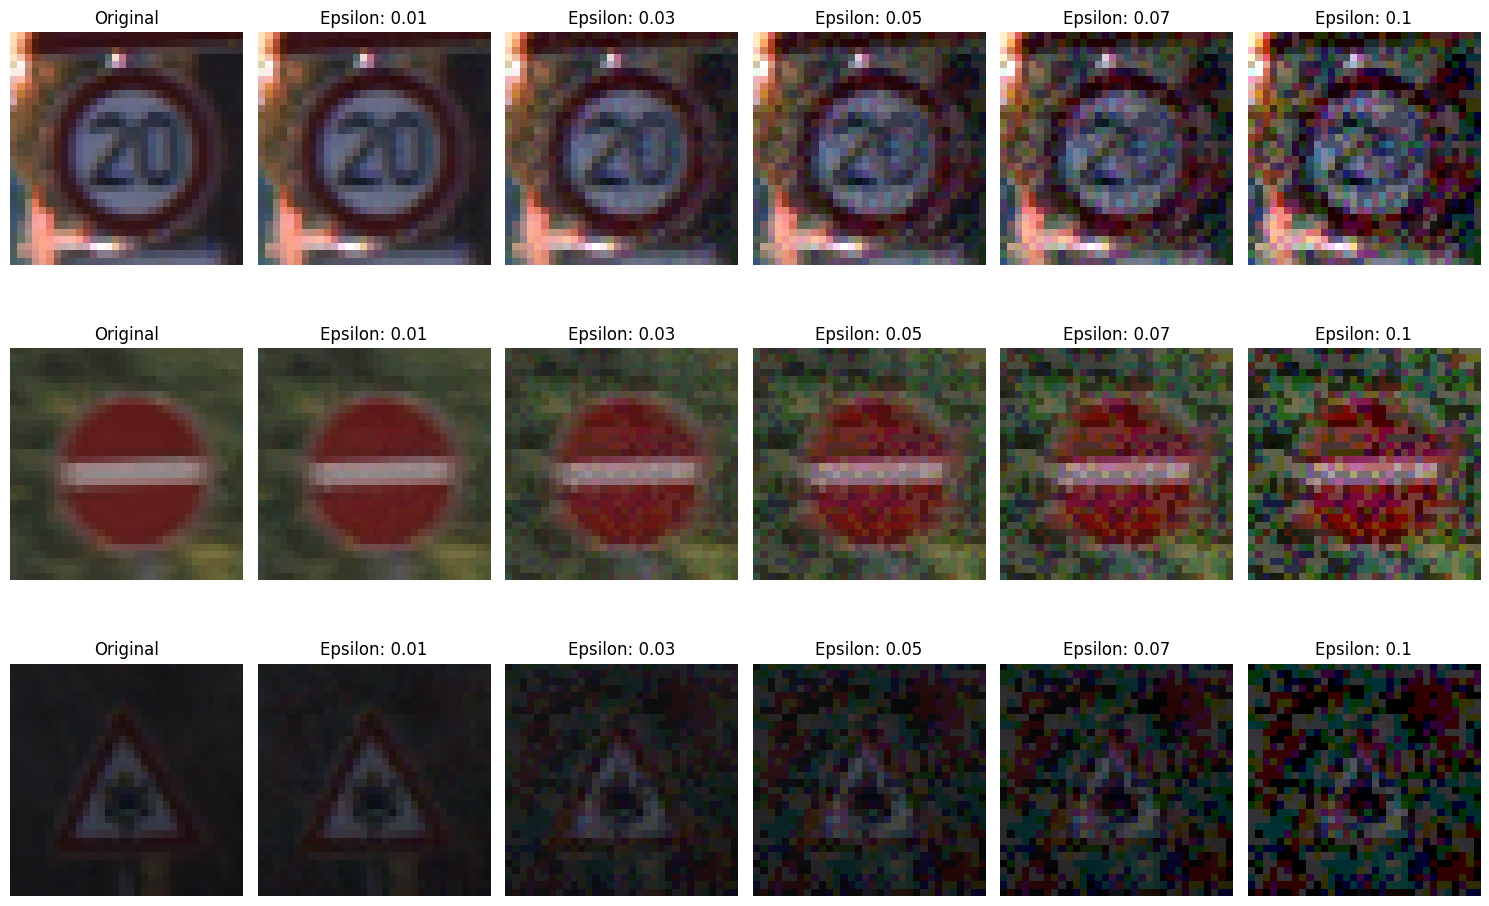

In [ ]:

# Function to generate adversarial samples
def generate_adversarial_samples(model, data, target, epsilon):
    #data should be normalized, i.e, output of  the data of the dataloader
    data.requires_grad = True
    # model=model.to(device)
    target=target.to(device)
    data=data.to(device)
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    data_denorm = denorm(data)
    perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
    perturbed_data = transforms.Normalize((0.5,), (0.5,))(perturbed_data)
    #output is also normalized adversarial data
    return perturbed_data

# Randomly pick 3 classes from the test set
random_classes = random.sample(range(43), 3)
epsilon_values = [0.01, 0.03, 0.05, 0.07, 0.1]

# Generate and visualize adversarial samples
fig, axes = plt.subplots(len(random_classes), len(epsilon_values) + 1, figsize=(15, 10))

for i, cls in enumerate(random_classes):
    for data, target in test_loader:
        if target.item() == cls:
            # Plot original image
            data=data.to(device)
            data_denorm = denorm(data)  # Restore the data to its original scale for plotting
            axes[i, 0].imshow(np.transpose(data_denorm.squeeze().cpu().numpy(), (1, 2, 0)))
            axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')

            # Plot adversarial samples for different epsilon values
            for j, epsilon in enumerate(epsilon_values):
                adv_data = generate_adversarial_samples(model, data, target, epsilon) #input and output are normalized
                data_denorm = denorm(adv_data)  # Restore the data to its original scale
                axes[i, j + 1].imshow(np.transpose(data_denorm.squeeze().detach().cpu().numpy(), (1, 2, 0)))
                axes[i, j + 1].set_title(f"Epsilon: {epsilon}")
                axes[i, j + 1].axis('off')
            break

plt.tight_layout()
plt.show()

### 5.3 Evaluate Adversarial Samples

In [ ]:
# device='cpu'
# # Function to generate adversarial samples
# def generate_adversarial_samples(model, data, target, epsilon):
#     data.requires_grad = True  # Ensure requires_grad is set to True
#     output = model(data)
#     loss = F.cross_entropy(output, target)
#     model.zero_grad()
#     loss.backward()
#     data_grad = data.grad.data
#     perturbed_data = fgsm_attack(data, epsilon, data_grad)
#     return perturbed_data


def evaluate_adversarial_samples(model, test_loader, epsilon):
    model.eval()
    all_preds = []
    all_labels = []
    # with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        adv_data = generate_adversarial_samples(model, data, target, epsilon)
        output = model(adv_data)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1

# Set the epsilon value for FGSM (largest value for visually indistinguishable images)
epsilon = 0.01  # Adjust this value based on your observations

# Evaluate the model on adversarial samples
adv_accuracy, adv_f1 = evaluate_adversarial_samples(model, test_loader, epsilon)
print(f"Adversarial Test Accuracy: {adv_accuracy:.4f}")
print(f"Adversarial Test F1 Score: {adv_f1:.4f}")

Adversarial Test Accuracy: 0.6032
Adversarial Test F1 Score: 0.6130


### 5.4 Visualize Misclassified Adversarial Samples

In [ ]:
# Function to evaluate the model on adversarial samples and show misclassifications
def evaluate_and_show_misclassifications(model, test_loader, epsilon):
    model.eval()
    model=model.to(device)
    misclassified_examples = []
    # with torch.no_grad():
    # std=[0.5, 0.5, 0.5]
    # mean=[0.5, 0.5, 0.5]
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Original prediction
        output = model(data)
        _, orig_pred = torch.max(output, 1)

        # Generate adversarial sample
        adv_data = generate_adversarial_samples(model, data, target, epsilon)

        # Adversarial prediction
        output = model(adv_data)
        _, adv_pred = torch.max(output, 1)

        # data=data * torch.tensor(std).view(3, 1, 1).to(device)
        # data=data + torch.tensor(mean).view(3, 1, 1).to(device)
        data_denorm=denorm(data)
        adv_data_denorm=denorm(adv_data)
        # Check for misclassification
        if orig_pred.item() == target.item() and adv_pred.item() != target.item():
            misclassified_examples.append((data_denorm.squeeze().cpu(), adv_data_denorm.squeeze().cpu(), target.item(), adv_pred.item()))

    return misclassified_examples

# Set the epsilon value for FGSM (largest value for visually indistinguishable images)
epsilon = 0.01  # Adjust this value based on your observations

# Evaluate the model and get misclassified examples
misclassified_examples = evaluate_and_show_misclassifications(model, test_loader, epsilon)


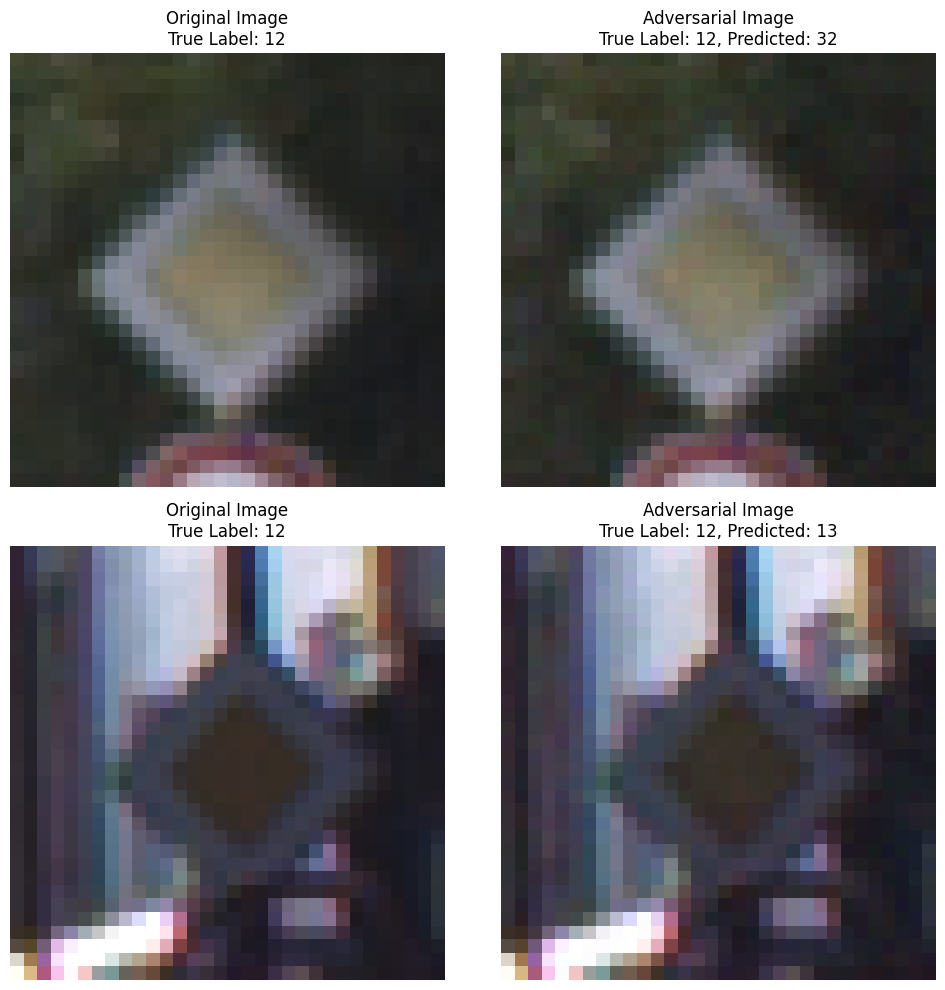

In [ ]:
# Show some misclassified examples
fig, axes = plt.subplots(2, 2, figsize=(10, 2 * 5))

for i, (orig_img, adv_img, true_label, adv_label) in enumerate(misclassified_examples):

    if i==2: break
    axes[i, 0].imshow(np.transpose(orig_img.detach().cpu().numpy(), (1, 2, 0)))
    axes[i, 0].set_title(f"Original Image\nTrue Label: {true_label}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(np.transpose(adv_img.detach().cpu().numpy(), (1, 2, 0)))
    axes[i, 1].set_title(f"Adversarial Image\nTrue Label: {true_label}, Predicted: {adv_label}")
    axes[i, 1].axis('off')
    # plt.show()

plt.tight_layout()
plt.show()

## 6 Finetuning a Neural Network
### 6.1 Loading a Pre-trained VGG Network

Epoch 1/40, Training Loss: 3.5099, Validation Loss: 3.2858
Epoch 2/40, Training Loss: 3.2734, Validation Loss: 3.2273
Epoch 3/40, Training Loss: 3.2217, Validation Loss: 3.1905
Epoch 4/40, Training Loss: 3.1886, Validation Loss: 3.1514
Epoch 5/40, Training Loss: 3.1489, Validation Loss: 3.1311
Epoch 6/40, Training Loss: 3.1187, Validation Loss: 3.1069
Epoch 7/40, Training Loss: 3.1037, Validation Loss: 3.1041
Epoch 8/40, Training Loss: 3.1004, Validation Loss: 3.1024
Epoch 9/40, Training Loss: 3.0976, Validation Loss: 3.0865
Epoch 10/40, Training Loss: 3.0749, Validation Loss: 3.0658
Epoch 11/40, Training Loss: 3.0518, Validation Loss: 3.0424
Epoch 12/40, Training Loss: 3.0354, Validation Loss: 3.0309
Epoch 13/40, Training Loss: 3.0264, Validation Loss: 3.0273
Epoch 14/40, Training Loss: 3.0234, Validation Loss: 3.0276
Epoch 15/40, Training Loss: 3.0229, Validation Loss: 3.0259
Epoch 16/40, Training Loss: 3.0180, Validation Loss: 3.0019
Epoch 17/40, Training Loss: 2.9941, Validation Lo

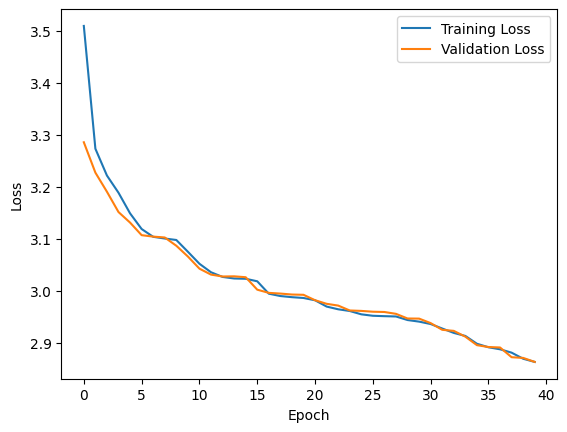

In [ ]:
import torch.utils.data as data

# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# # Load the training and test datasets without transformations
train_dataset = datasets.GTSRB(root='./data', split='train', transform=None, download=True)
test_dataset = datasets.GTSRB(root='./data', split='test', transform=None, download=True)

# Apply the transformations to the resized datasets
train_dataset = [(transform(img), label) for img, label in train_dataset]
test_dataset = [(transform(img), label) for img, label in test_dataset]

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for the training, validation, and test datasets
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)
# Assuming you have a dataset class `MyDataset`


# Load the pretrained VGG-11 model with batch normalization
model = vgg11_bn(weights=torchvision.models.VGG11_BN_Weights.IMAGENET1K_V1)

# Freeze the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False


## METHOD TO FREEZE SPECIFIC SUB-Layers of the model from training.

# def set_grad_stat(group,value):
#   for layer in group:
#     for params in  layer.parameters():
#       params.requires_grad=value
#     layer=layer.train(value)

# def check_grad_stat(group):
#   temp=[]
#   for params in group.parameters():
#    temp.append(params.requires_grad)
#   print('model training stat:',group.training)
#   return set(temp).pop()

## CODE TO COMPARE A MODEL PRE AND POST FREEZING LAYERS FOR CONFORMATION.

# def compare_models(model_1, model_2):
#     models_differ = 0
#     for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
#         if torch.equal(key_item_1[1], key_item_2[1]):
#             pass
#         else:
#             models_differ += 1
#             if (key_item_1[0] == key_item_2[0]):
#                 print('Mismtach found at', key_item_1[0])
#             else:
#                 raise Exception
#     if models_differ == 0:
#         print('Models match perfectly! :)')



# Replace the classifier part of the model
num_classes = 43  # Adjust this based on your dataset
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.Softmax(dim=1)
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# model=nn.DataParallel(model)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

#setting optimized for specific subset of parameters.
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=initial_lr)

# Training loop
num_epochs = 40
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # Evaluate the model on the test set
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# accuracy = accuracy_score(all_labels, all_preds)
# f1 = f1_score(all_labels, all_preds, average='weighted')

# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test F1 Score: {f1:.4f}")

### 6.1 Network Performance Evaluation

In [ ]:
# Evaluate the model on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.8783
Test F1 Score: 0.8633


## 7. Visualizing Class Activation Maps (CAMs)
CAM, short for Class Acvtivation Mapping, is a technique that visualizes the regions of input that are "important" for predictions from these models - or visual explanations. Relying on localization properties of a final global average pooling layer in the network, CAM uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the discriminative regions in the image.
Reference: [Learning Deep Features for Discriminative Localization. (Zhou et al.)](http://cnnlocalization.csail.mit.edu/)

### Tools
1. [CAM-Visualizer: Class Activation Map Visualization Toolkit](https://www.intel.com/content/www/us/en/developer/articles/reference-implementation/class-activation-map-visualizer.html)

### Interactive Demos
1. [CNN Explainer](https://poloclub.github.io/cnn-explainer/)
###
2. [Summit](https://fredhohman.com/summit/)

### Additional Materials
1. [Overview of Class Activation Maps for Visualization Explainability](https://arxiv.org/pdf/2309.14304)
###
2. [Various CAM visualizatoin methods with tutorials](https://www.pinecone.io/learn/class-activation-maps/)
###
3. [Activation Atlas](https://distill.pub/2019/activation-atlas/)

In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# Initialize GradCAM with the model and the target layer
cam_extractor = GradCAM(model, target_layer='features.27')
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [ ]:
# Function to visualize CAMs
# set the evaluation mode
def visualize_cam(model, cam_extractor, data_loader, device):
    count=0
    model.eval()
    for i, (inputs, labels) in enumerate(data_loader):


        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        inputs.requires_grad = True  # Ensure requires_grad is set to True
        outputs = model(inputs)
        max_prob, preds = torch.max(outputs, 1)

        if max_prob.item() <= 0.95:
            # Generate CAM
            count+=1
            activation_map = cam_extractor(preds.item(), outputs)
            # print(outputs)

            # Convert tensor to PIL image
            inputs=inputs * torch.tensor(std).view(3, 1, 1).to(device)
            inputs=inputs + torch.tensor(mean).view(3, 1, 1).to(device)
            img = transforms.ToPILImage(mode='RGB')(inputs[0].squeeze().cpu())

            # Convert activation map to PIL image
            mask = activation_map[0].squeeze().cpu().numpy()
            mask = Image.fromarray(mask, mode='F')
            # print(mask.size)
            # Overlay the CAM on the image
            result = overlay_mask(img, mask, alpha=0.5)
            # print(result.size)
            # print(img.size)
            # Display the image and CAM
            plt.figure(figsize=(7, 3))
            plt.subplot(1, 2, 1)
            # plt.imshow(np.transpose(inputs.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            plt.imshow(img)
            plt.title(f"Original Image\nTrue Label: {labels.item()}")
            plt.axis('off')

            # print(np.asarray(img).shape)
            plt.subplot(1, 2, 2)
            plt.imshow(np.asarray(result))
            plt.title(f"CAM\nPredicted: {preds.item()}")
            plt.axis('off')

            plt.show()

            if count == 15:  # Show only a few examples
                break


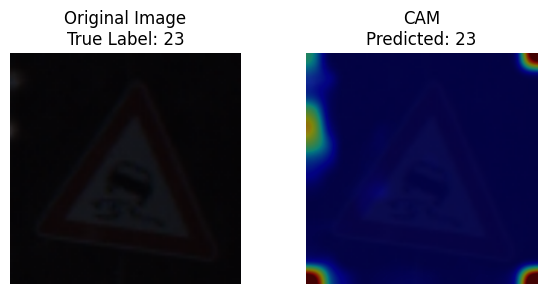

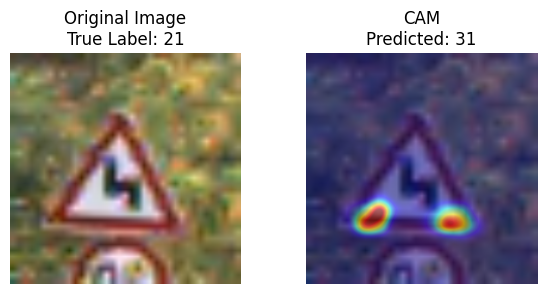

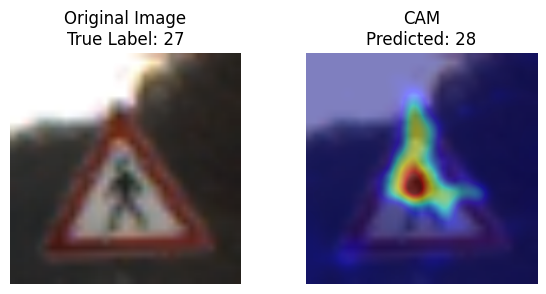

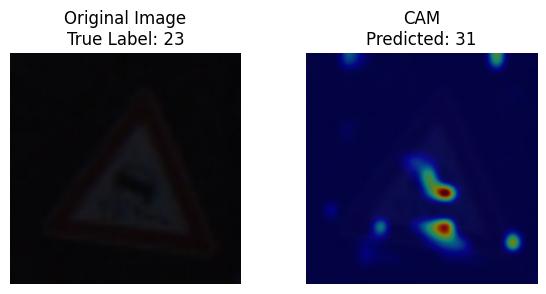

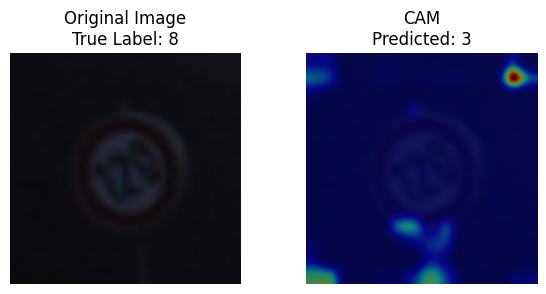

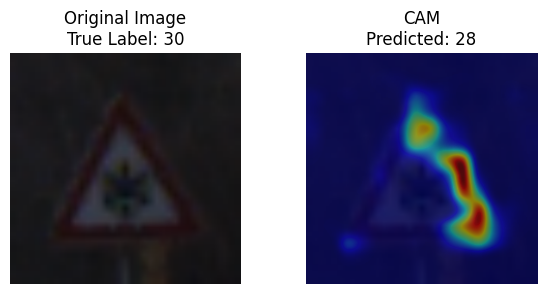

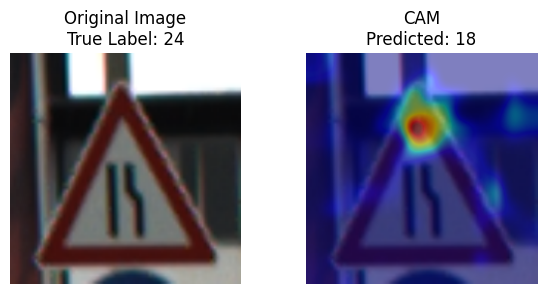

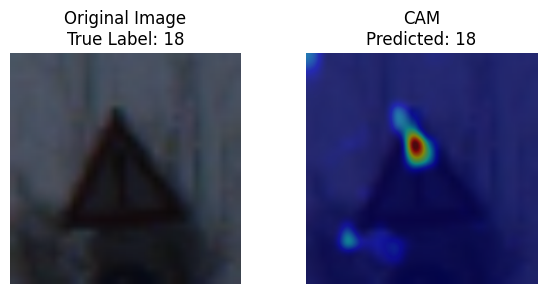

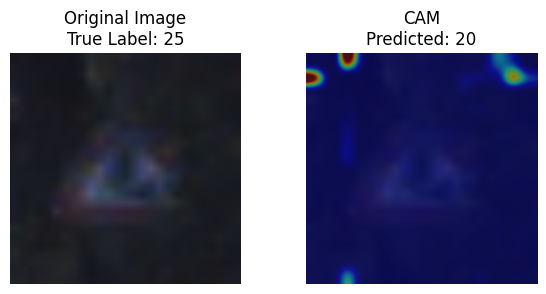

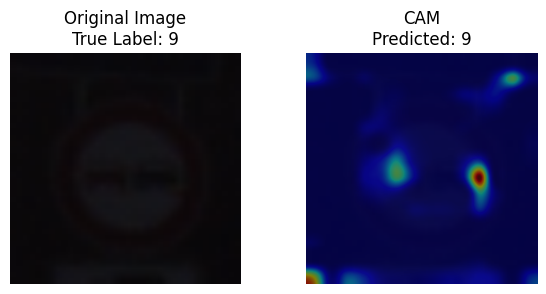

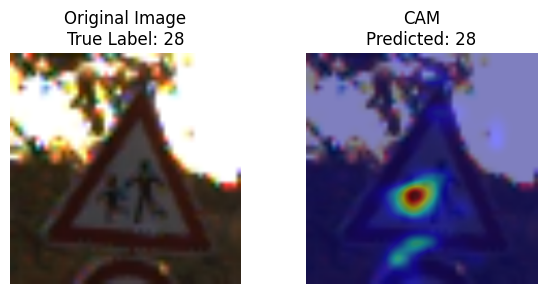

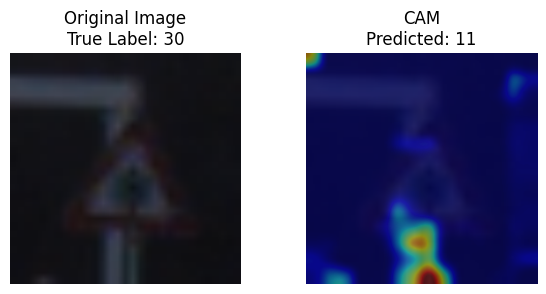

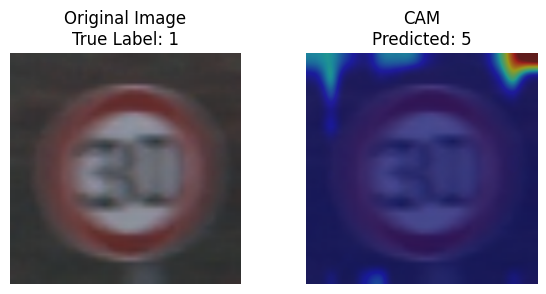

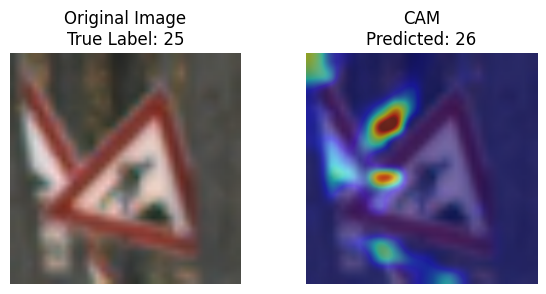

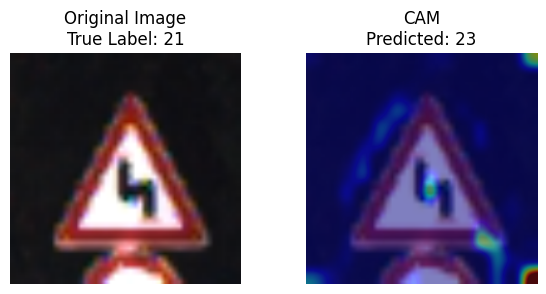

In [ ]:
# Visualize CAMs for a few test samples
visualize_cam(model, cam_extractor, test_loader, device)

### 7.1 CAM Visualization - Pre-trained Model

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


test_data=datasets.Imagenette(root='./data', split='val', download=True, transform=transform)

dataloader = data.DataLoader(dataset=test_data, shuffle=False, batch_size=1)

# initialize the VGG model
vgg = vgg11_bn(weights=torchvision.models.VGG11_BN_Weights.IMAGENET1K_V1)



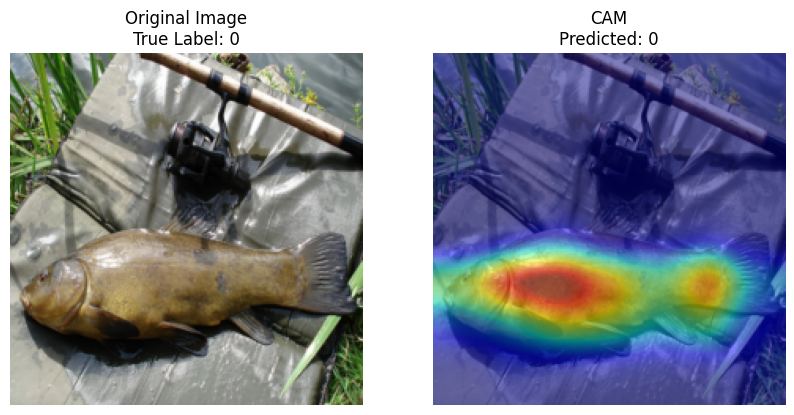

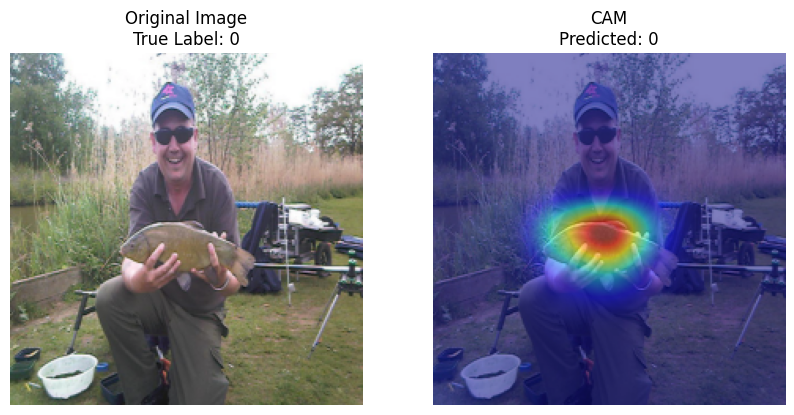

In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# Initialize GradCAM with the model and the target layer
cam_extractor = GradCAM(vgg, target_layer='features.28')
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
vgg=vgg.to(device)

# Visualize CAMs for a few test samples

visualize_cam(vgg, cam_extractor, dataloader, device)

# Assignment

## Task 1 - 4 Marks

Load the Oxford-IIIT Pets dataset from Torchvision datasets (both train and test partition).

Randomly shuffle the train partition and split the train partition further into training and validation
sets (80% training, 20% validation).

Show the class distribution on the training partition.

Define transform to resize the images to size 224 x 224. Define Dataloaders for training,
validation, and test sets that use this transform.

## Task 2 - 4 Marks

Load the pretrained ResNet-18 model with the default weights (trained on ImageNet)

Extract the features after the GAP layer of the ResNet-18 model. Replace the final FC layer of
the model with one or more 1x1 convolutional layers, where the number of 1x1 convolutional
filters in the last layer should be the number of classes of this dataset.

## Task 3 - 2 Marks

Train the model using SGD and a suitable learning rate.


## Task 4 - 1 Mark

Show the training and validation losses as a function of the number of epochs.


## Task 4 - 2 Marks

Report the classification performance on the test partition of the dataset. Show the confusion
matrix, accuracy, and F1 score.

## Task 5 - 3 Marks

Use Grad-CAM to visualize the class activation maps on a few test images (randomly sample
5). You can use the torchcam library for this question

## Task 6 - 4 Marks

Implement a targeted Fast Gradient Sign Method (FGSM) adversarial attack to modify test images originally classified as "American Bulldog" so that they are misclassified as "Pug" by the trained model. 
Report the success rate of the attack, which is defined as the fraction of samples that were initially correctly classified as "American Bulldog" but misclassified as "Pug" after the adversarial perturbation. 
